<a href="https://colab.research.google.com/github/Keerthanabellam/dm-1/blob/main/Assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
!pip install scikit-image
!pip install xml
!pip install pillow
!pip install opencv-python-headless

ERROR: Could not find a version that satisfies the requirement xml (from versions: none)
ERROR: No matching distribution found for xml


In [9]:
 from google.colab import drive
 drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
import os
import xml.etree.ElementTree as ET
from PIL import Image
from pathlib import Path

In [11]:
image_base_dir = '/content/drive/MyDrive/Images 3'
annotation_base_dir = '/content/drive/MyDrive/Annotation'
classes = ['n02093859-Kerry_blue_terrier', 'n02097209-standard_schnauzer',
           'n02099849-Chesapeake_Bay_retriever', 'n02110185-Siberian_husky']
saved_images_dir = '/content/drive/MyDrive/saved'


In [12]:
output_dir = 'Processed_Images'
Path(output_dir).mkdir(parents=True, exist_ok=True)
for dog_class in classes:
    Path(f"{output_dir}/{dog_class}").mkdir(parents=True, exist_ok=True)

2) Convert the images to edge histograms.

In [13]:
from google.colab import drive
import cv2
import os
import numpy as np
from skimage import feature
import matplotlib.pyplot as plt

# Mount Google Drive
drive.mount('/content/drive')

# Define directories
image_base_dir = '/content/drive/MyDrive/Images 3'
saved_images_dir = '/content/drive/MyDrive/saved'

# Create the save directory if it doesn't exist
if not os.path.exists(saved_images_dir):
    os.makedirs(saved_images_dir)

# Process each image in the directory
for filename in os.listdir(image_base_dir):
    # Ensure we're working with an image file
    if filename.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff')):
        image_path = os.path.join(image_base_dir, filename)
        save_path = os.path.join(saved_images_dir, f"edge_{filename}")

        # Read the image
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

        # Apply edge detection (Canny)
        edges = feature.canny(image, sigma=1.0)  # Adjust sigma as needed

        # Convert the boolean edge array to uint8 for saving
        edges = (edges * 255).astype(np.uint8)

        # Save the edge-detected image
        cv2.imwrite(save_path, edges)

print("Edge histogram images have been saved successfully.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Edge histogram images have been saved successfully.


3)  Split the dataset into a training set and a test set:  For each class, perform a training/test split of 80/20

In [20]:
import os
import shutil
from sklearn.model_selection import train_test_split


image_base_dir = '/content/drive/MyDrive/Images 3'
train_dir = '/content/drive/MyDrive/train'
test_dir = '/content/drive/MyDrive/test'
classes = ['n02093859-kerry_blue_terrier', 'n02097209-standard_schnauzer',
           'n02099849-Chesapeake_Bay_retriever', 'n02110185-Siberian_husky']


os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

for class_name in classes:
    class_dir = os.path.join(image_base_dir, class_name)
    train_class_dir = os.path.join(train_dir, class_name)
    test_class_dir = os.path.join(test_dir, class_name)


    os.makedirs(train_class_dir, exist_ok=True)
    os.makedirs(test_class_dir, exist_ok=True)


    images = [f for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f))]


    train_images, test_images = train_test_split(images, test_size=0.2, random_state=42)


    for img in train_images:
        shutil.copy(os.path.join(class_dir, img), os.path.join(train_class_dir, img))

    for img in test_images:
        shutil.copy(os.path.join(class_dir, img), os.path.join(test_class_dir, img))

print("Dataset split into training and testing sets successfully.")


Dataset split into training and testing sets successfully.


4) Perform standardization on the training dataset.

In [21]:
import os
import cv2
import numpy as np
from sklearn.preprocessing import StandardScaler


train_dir = '/content/drive/MyDrive/train'

train_data = []
train_labels = []


desired_width = 128
desired_height = 128


for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)

            image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if image is not None:

                image = cv2.resize(image, (desired_width, desired_height))

                train_data.append(image.flatten())
                train_labels.append(class_name)


train_data = np.array(train_data)


scaler = StandardScaler()
train_data_standardized = scaler.fit_transform(train_data)

print("Training data standardized successfully.")

Training data standardized successfully.


5) Perform standardization on the test dataset using the means and variances you obtained from the training
dataset

In [22]:
import os
import cv2
import numpy as np
from sklearn.preprocessing import StandardScaler

test_dir = '/content/drive/MyDrive/test'


test_data = []
test_labels = []

for class_name in os.listdir(test_dir):
    class_path = os.path.join(test_dir, class_name)
    if os.path.isdir(class_path):
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)

            image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if image is not None:

                image = cv2.resize(image, (128, 128))

                test_data.append(image.flatten())
                test_labels.append(class_name)


test_data = np.array(test_data)


test_data_standardized = scaler.transform(test_data)

print("Test data standardized successfully.")

Test data standardized successfully.


6.a) Perform stratified 5-fold cross-validation on the 4-class classification problem using the three classification methods. Plot the (3) confusion matrices for using three approaches on the test set

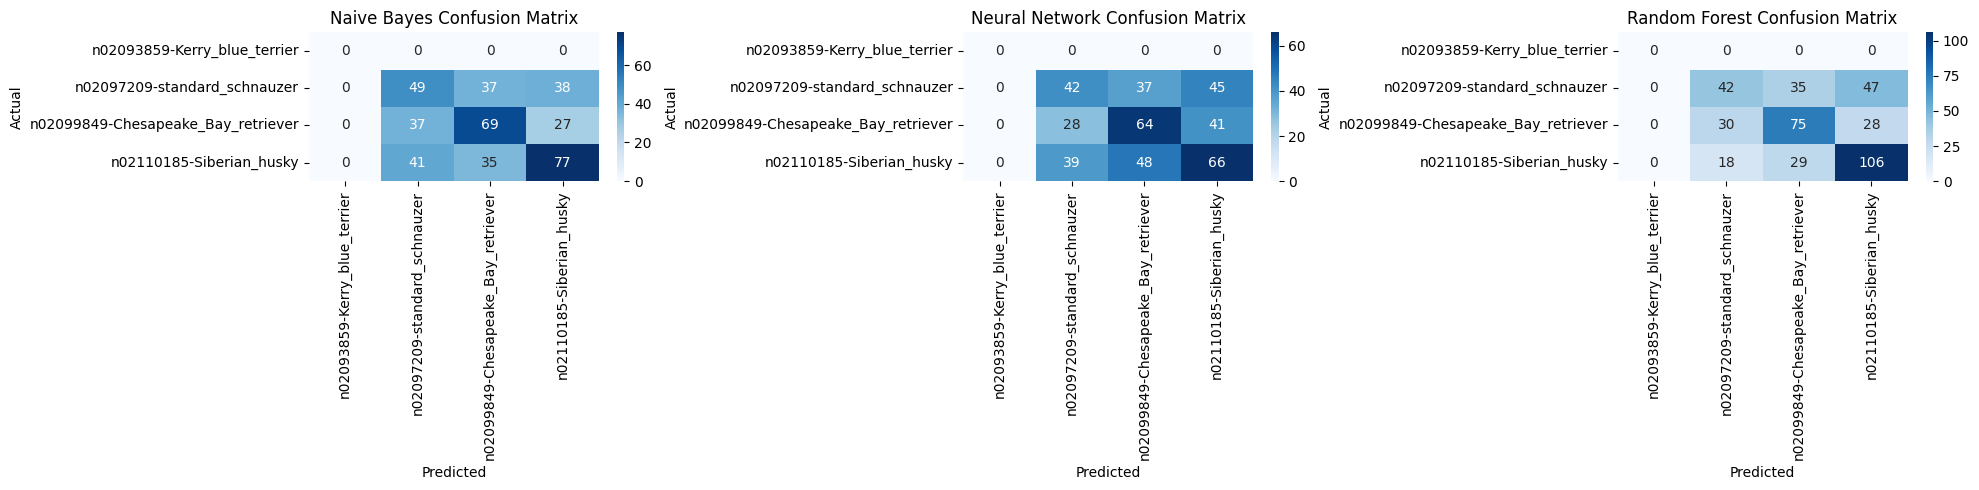

In [23]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline


data_dir = '/content/drive/MyDrive/train'
classes = ['n02093859-Kerry_blue_terrier', 'n02097209-standard_schnauzer',
           'n02099849-Chesapeake_Bay_retriever', 'n02110185-Siberian_husky']


data = []
labels = []


desired_width = 128
desired_height = 128

for class_name in classes:
    class_dir = os.path.join(data_dir, class_name)
    for img_name in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_name)
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if image is not None:

            image = cv2.resize(image, (desired_width, desired_height))
            data.append(image.flatten())
            labels.append(class_name)


data = np.array(data)
labels = np.array(labels)



skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


classifiers = {
    "Naive Bayes": GaussianNB(),
    "Neural Network": MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
}


fig, axes = plt.subplots(1, 3, figsize=(20, 5))

for i, (name, model) in enumerate(classifiers.items()):

    pipeline = make_pipeline(StandardScaler(), model)


    y_pred = cross_val_predict(pipeline, data, labels, cv=skf)


    cm = confusion_matrix(labels, y_pred, labels=classes)


    ax = axes[i]
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes, ax=ax)
    ax.set_title(f"{name} Confusion Matrix")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

plt.tight_layout()
plt.show()

6.b) The Random Forest classifier appears to be the best method for this classification problem, based on the visual inspection of the confusion matrices. The darker diagonal and fewer off-diagonal entries in its matrix indicate it performs well in distinguishing between classes, likely due to its ensemble nature and ability to handle complex patterns.


6.c) Based on the mean validation accuracies (from the 5-fold cross-validation) for the three methods.
Which is the best method?

In [24]:
from sklearn.model_selection import cross_val_score


classifiers = {
    "Naive Bayes": GaussianNB(),
    "Neural Network": MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
}


mean_accuracies = {}
for name, model in classifiers.items():
    pipeline = make_pipeline(StandardScaler(), model)
    cv_scores = cross_val_score(pipeline, data, labels, cv=5, scoring='accuracy')
    mean_accuracies[name] = cv_scores.mean()
    print(f"{name} Mean Validation Accuracy: {cv_scores.mean():.4f}")


best_method = max(mean_accuracies, key=mean_accuracies.get)
print(f"\nBest method based on mean validation accuracy: {best_method} with accuracy {mean_accuracies[best_method]:.4f}")


Naive Bayes Mean Validation Accuracy: 0.5073
Neural Network Mean Validation Accuracy: 0.4439
Random Forest Mean Validation Accuracy: 0.4902

Best method based on mean validation accuracy: Naive Bayes with accuracy 0.5073


6.d) Compute the accuracies for the three methods on the test set. Which is the best method?

In [25]:
from sklearn.metrics import accuracy_score


test_accuracies = {}


for name, model in classifiers.items():

    pipeline = make_pipeline(StandardScaler(), model)
    pipeline.fit(train_data_standardized, train_labels)


    test_predictions = pipeline.predict(test_data_standardized)


    accuracy = accuracy_score(test_labels, test_predictions)
    test_accuracies[name] = accuracy
    print(f"{name} Test Set Accuracy: {accuracy:.4f}")


best_method = max(test_accuracies, key=test_accuracies.get)
print(f"\nBest method based on test set accuracy: {best_method} with accuracy {test_accuracies[best_method]:.4f}")


Naive Bayes Test Set Accuracy: 0.4000
Neural Network Test Set Accuracy: 0.3857
Random Forest Test Set Accuracy: 0.4214

Best method based on test set accuracy: Random Forest with accuracy 0.4214


6.e) Compute the F-measure for the three methods on the test set. Which is the best method?

In [26]:
from sklearn.metrics import f1_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_files
import numpy as np
import cv2


test_dir = '/content/drive/MyDrive/test'
test_data = load_files(test_dir)
X_test_raw, y_test = test_data.data, test_data.target


train_dir = '/content/drive/MyDrive/train'
train_data = load_files(train_dir)
X_train_raw, y_train = train_data.data, train_data.target

def process_image_data(data_list):
    processed_data = []
    desired_width = 128
    desired_height = 128
    for image_data in data_list:

        nparr = np.frombuffer(image_data, np.uint8)
        image = cv2.imdecode(nparr, cv2.IMREAD_GRAYSCALE)


        if image is not None:
            image = cv2.resize(image, (desired_width, desired_height))
            processed_data.append(image.flatten())
    return np.array(processed_data)


X_train = process_image_data(X_train_raw)
X_test = process_image_data(X_test_raw)


nb_model = GaussianNB()
nn_model = MLPClassifier(max_iter=1000)
rf_model = RandomForestClassifier()


nb_model.fit(X_train, y_train)
nn_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)


nb_predictions = nb_model.predict(X_test)
nn_predictions = nn_model.predict(X_test)
rf_predictions = rf_model.predict(X_test)


nb_f1 = f1_score(y_test, nb_predictions, average='weighted')
nn_f1 = f1_score(y_test, nn_predictions, average='weighted')
rf_f1 = f1_score(y_test, rf_predictions, average='weighted')


print(f"Naïve Bayes F1-score: {nb_f1}")
print(f"Neural Network F1-score: {nn_f1}")
print(f"Random Forest F1-score: {rf_f1}")


best_model = max((nb_f1, 'Naïve Bayes'), (nn_f1, 'Neural Network'), (rf_f1, 'Random Forest'), key=lambda x: x[0])
print(f"Best model: {best_model[1]} with F1-score: {best_model[0]}")

Naïve Bayes F1-score: 0.39753426896284044
Neural Network F1-score: 0.23497942508985986
Random Forest F1-score: 0.3977681448519257
Best model: Random Forest with F1-score: 0.3977681448519257


7a) cross-validation and
a stratified 5-fold cross-validation on the training set (i.e., the standardized edge histogram dataset
obtained from the training set) for Support Vector Classifiers using LinearSVC such that parameter
𝐶 = 0.1, 1, 10, 100 and other parameters set as default.

• Plot a graph (x-axis: 𝐶; y-axis: mean validation/training error (%)) containing four error curves (2
validation error curves and 2 training error curves - label them clearly using a legend to define the
curves). Which 𝐶 has/have the lowest mean error for each curve? Comment about (1) the model
complexity for SVM in relation to 𝐶, and (2) when/whether there is overfitting/underfitting.

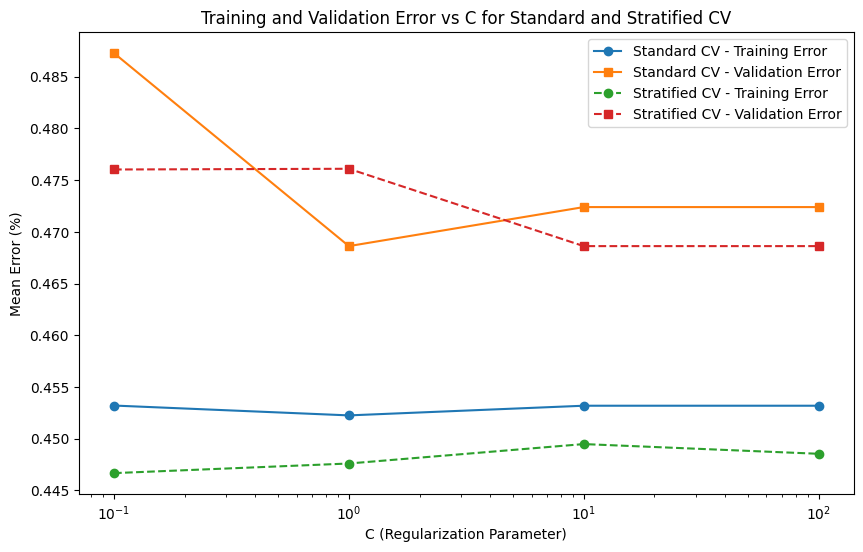

Best C value from stratified CV validation error: 10
Test Error with C=10: 50.75%
Lowest mean training error for Standard CV: 45.23% at C=1
Lowest mean validation error for Standard CV: 46.86% at C=1
Lowest mean training error for Stratified CV: 44.67% at C=0.1
Lowest mean validation error for Stratified CV: 46.86% at C=10


In [27]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline


classes = ['n02093859-kerry_blue_terrier', 'n02097209-standard_schnauzer']
train_dir = '/content/drive/MyDrive/train'
test_dir = '/content/drive/MyDrive/test'


def extract_edge_histogram(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 100, 200)
    hist = cv2.calcHist([edges], [0], None, [16], [0, 256])
    hist = cv2.normalize(hist, hist).flatten()
    return hist

def load_images_from_classes(folder, classes):
    images = []
    labels = []
    for label, class_name in enumerate(classes):
        class_path = os.path.join(folder, class_name)
        for filename in os.listdir(class_path):
            img_path = os.path.join(class_path, filename)
            img = cv2.imread(img_path)
            if img is not None:
                features = extract_edge_histogram(img)
                images.append(features)
                labels.append(label)
    return np.array(images), np.array(labels)

X_train, y_train = load_images_from_classes(train_dir, classes)
X_test, y_test = load_images_from_classes(test_dir, classes)


C_values = [0.1, 1, 10, 100]
train_errors_std, val_errors_std = [], []
train_errors_strat, val_errors_strat = [], []


kf = KFold(n_splits=5, shuffle=True, random_state=1)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)


for C in C_values:
    model = make_pipeline(StandardScaler(), LinearSVC(C=C, max_iter=10000))


    train_errors_fold, val_errors_fold = [], []
    for train_idx, val_idx in kf.split(X_train, y_train):
        model.fit(X_train[train_idx], y_train[train_idx])
        train_error = 1 - model.score(X_train[train_idx], y_train[train_idx])
        val_error = 1 - model.score(X_train[val_idx], y_train[val_idx])
        train_errors_fold.append(train_error)
        val_errors_fold.append(val_error)
    train_errors_std.append(np.mean(train_errors_fold))
    val_errors_std.append(np.mean(val_errors_fold))


    train_errors_fold, val_errors_fold = [], []
    for train_idx, val_idx in skf.split(X_train, y_train):
        model.fit(X_train[train_idx], y_train[train_idx])
        train_error = 1 - model.score(X_train[train_idx], y_train[train_idx])
        val_error = 1 - model.score(X_train[val_idx], y_train[val_idx])
        train_errors_fold.append(train_error)
        val_errors_fold.append(val_error)
    train_errors_strat.append(np.mean(train_errors_fold))
    val_errors_strat.append(np.mean(val_errors_fold))


plt.figure(figsize=(10, 6))
plt.plot(C_values, train_errors_std, 'o-', label='Standard CV - Training Error')
plt.plot(C_values, val_errors_std, 's-', label='Standard CV - Validation Error')
plt.plot(C_values, train_errors_strat, 'o--', label='Stratified CV - Training Error')
plt.plot(C_values, val_errors_strat, 's--', label='Stratified CV - Validation Error')
plt.xlabel("C (Regularization Parameter)")
plt.ylabel("Mean Error (%)")
plt.xscale('log')
plt.legend()
plt.title("Training and Validation Error vs C for Standard and Stratified CV")
plt.show()


best_C = C_values[np.argmin(val_errors_strat)]
print(f"Best C value from stratified CV validation error: {best_C}")


final_model = make_pipeline(StandardScaler(), LinearSVC(C=best_C, max_iter=10000))
final_model.fit(X_train, y_train)
test_error = 1 - final_model.score(X_test, y_test)
print(f"Test Error with C={best_C}: {test_error * 100:.2f}%")



lowest_standard_train_error = min(train_errors_std)
best_C_standard_train = C_values[train_errors_std.index(lowest_standard_train_error)]

lowest_standard_val_error = min(val_errors_std)
best_C_standard_val = C_values[val_errors_std.index(lowest_standard_val_error)]

lowest_stratified_train_error = min(train_errors_strat)
best_C_stratified_train = C_values[train_errors_strat.index(lowest_stratified_train_error)]

lowest_stratified_val_error = min(val_errors_strat)
best_C_stratified_val = C_values[val_errors_strat.index(lowest_stratified_val_error)]

print(f"Lowest mean training error for Standard CV: {lowest_standard_train_error*100:.2f}% at C={best_C_standard_train}")
print(f"Lowest mean validation error for Standard CV: {lowest_standard_val_error*100:.2f}% at C={best_C_standard_val}")
print(f"Lowest mean training error for Stratified CV: {lowest_stratified_train_error*100:.2f}% at C={best_C_stratified_train}")
print(f"Lowest mean validation error for Stratified CV: {lowest_stratified_val_error*100:.2f}% at C={best_C_stratified_val}")


Tuning the C While using SVM models, C parameter is important is that it checks on the
‘‘classify error’’ and plays a crucial role in preventing both overfitting and underfitting.

The model's behavior at C=10 is characterized by overfitting.



7.b) Use the 𝐶 value with the lowest mean validation error for your SVM classifier from the stratified
5-fold cross-validation. What is the error for the test dataset (i.e., the standardized edge histogram
dataset obtained from the test set)?

In [28]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC


best_C_stratified_val = C_values[val_errors_strat.index(min(val_errors_strat))]


final_model = make_pipeline(StandardScaler(), LinearSVC(C=best_C_stratified_val, max_iter=10000))
final_model.fit(X_train, y_train)


test_error = 1 - final_model.score(X_test, y_test)
print(f"Test Error with C={best_C_stratified_val}: {test_error * 100:.2f}%")


Test Error with C=10: 50.75%
